In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Input bayesian dataset
data = pd.read_excel('data_new.xlsx', sheet_name='bayes-01')
feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5']
sns.set(style="whitegrid")

# Simply observe the distribution of the Bayesian data set
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  
fig.suptitle('Feature Distributions', fontsize=16)  

for i, feature in enumerate(feature_cols):
    row = i // 3  
    col = i % 3   
    ax = axes[row, col]
    
    sns.histplot(data[feature], kde=True, ax=ax, color='skyblue', bins=20)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

if len(feature_cols) < 6:
    for j in range(len(feature_cols), 6):
        row = j // 3
        col = j % 3
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.show()

### The data point with the PA score was determined by k-fold k-fold cross validation

Successfully loaded data from worksheet 'Bayes'

=== Detailed cross-validation results ===
Repeat  Fold  R²      MAE     RMSE    MSE     MRE     MAPE(%)   
----------------------------------------------------------------------
1       1     0.3149  0.0880  0.1196  0.0143  0.0635  6.35      
1       2     0.8261  0.0278  0.0351  0.0012  0.0183  1.83      
1       3     0.8989  0.0276  0.0338  0.0011  0.0187  1.87      
1       4     0.9403  0.0296  0.0335  0.0011  0.0204  2.04      
1       5     0.8776  0.0386  0.0513  0.0026  0.0280  2.80      
Rep1_Avg        0.7716  0.0423  0.0547  0.0041  0.0298  2.98      
----------------------------------------------------------------------
2       1     0.6813  0.0423  0.0550  0.0030  0.0288  2.88      
2       2     0.8295  0.0339  0.0424  0.0018  0.0233  2.33      
2       3     0.2054  0.0631  0.0850  0.0072  0.0416  4.16      
2       4     0.8780  0.0356  0.0445  0.0020  0.0229  2.29      
2       5     0.6890  0.0724  0.0849  0.0072  0.05

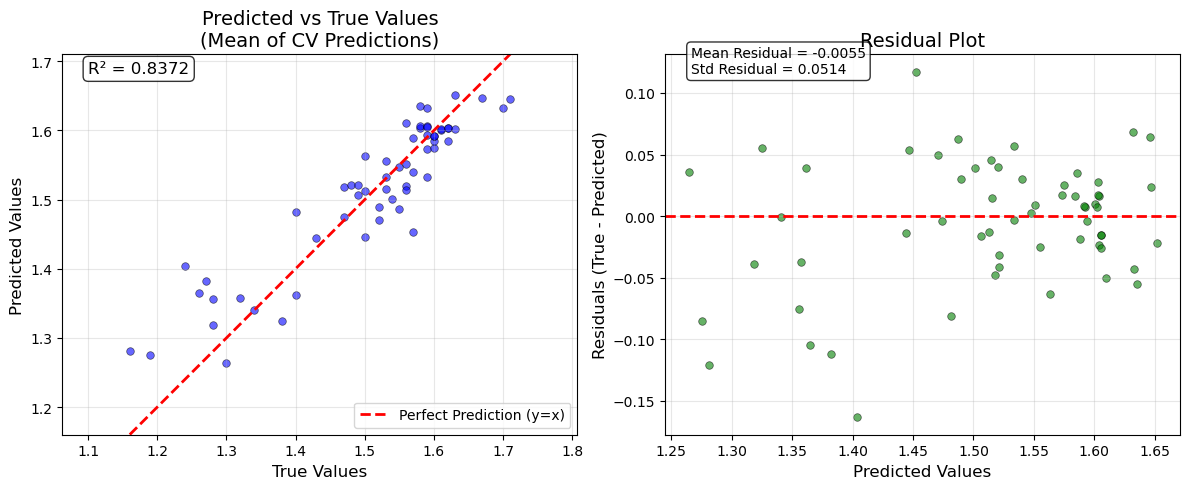

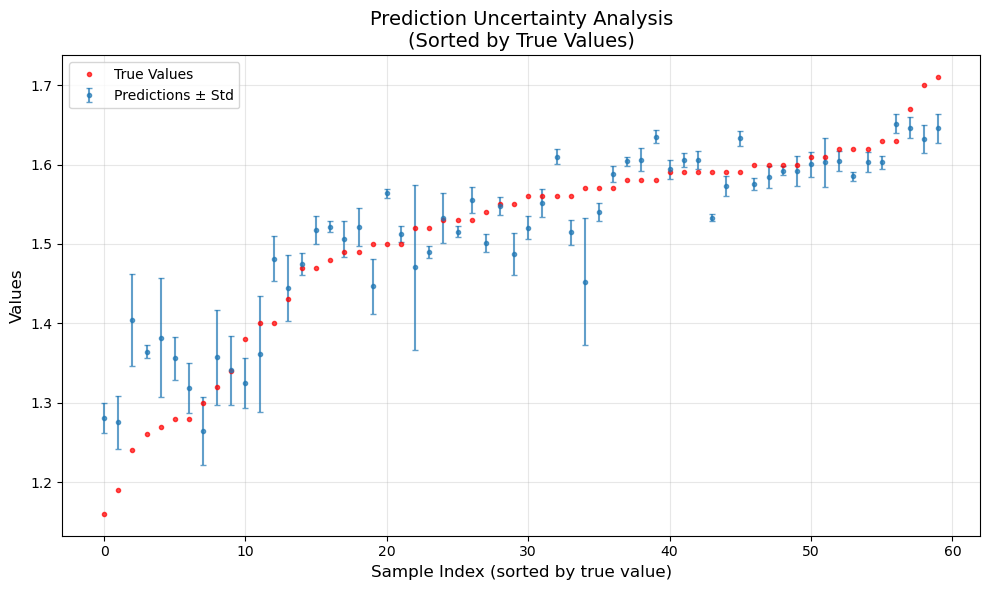


=== Figures generated ===
- prediction_analysis.png: Predicted vs True + Residual Plot
- prediction_uncertainty.png: Prediction Uncertainty Plot
Successfully saved data to file 'Sorted_data_col=0.6-bayes_detailed-PA-score.xlsx'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

class FileManager:
    def __init__(self, base_file='Initial_data2.xlsx'):
        self.base_file = base_file

    def load_data(self, sheet_name):
        """Load dataset from Excel"""
        try:
            data = pd.read_excel(self.base_file, sheet_name=sheet_name)
            print(f"Successfully loaded data from worksheet '{sheet_name}'")
            return data
        except Exception as e:
            print(f"Failed to load worksheet '{sheet_name}': {e}")
            return pd.DataFrame()

    @staticmethod
    def save_to_new_excel(data_dict, file_name='Sorted_data.xlsx'):
        """Save multiple DataFrames to different Excel sheets"""
        try:
            with pd.ExcelWriter(file_name, mode='w', engine='openpyxl') as writer:
                for sheet_name, df in data_dict.items():
                    df.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Successfully saved data to file '{file_name}'")
        except Exception as e:
            print(f"Failed to save data to file '{file_name}': {e}")


def load_and_preprocess_data(data):
    """Preprocess dataset: split features and target"""
    target_col = 'y1'
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    return X, y, data


def evaluate_model_and_store_predictions(X, y, model, num_repeats, num_folds):
    """Evaluate model performance using repeated K-Fold cross-validation"""
    all_r2_scores, all_mae_scores, all_rmse_scores = [], [], []
    all_mse_scores, all_mre_scores, all_mape_scores = [], [], []
    all_predictions = []

    # Initialize pointwise metrics storage
    pointwise_mse = pd.Series(0.0, index=X.index)
    pointwise_mre = pd.Series(0.0, index=X.index)
    pointwise_mape = pd.Series(0.0, index=X.index)

    print("\n=== Detailed cross-validation results ===")
    print(f"{'Repeat':<8}{'Fold':<6}{'R²':<8}{'MAE':<8}{'RMSE':<8}{'MSE':<8}{'MRE':<8}{'MAPE(%)':<10}")
    print("-" * 70)

    for j in range(num_repeats):
        cv = KFold(n_splits=num_folds, shuffle=True, random_state=j)
        fold_predictions = []

        for fold_idx, (train_index, test_index) in enumerate(cv.split(X, y), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)

            # Compute fold-level metrics
            r2_fold = r2_score(y_test, y_test_pred)
            mae_fold = mean_absolute_error(y_test, y_test_pred)
            rmse_fold = np.sqrt(mean_squared_error(y_test, y_test_pred))
            mse_fold = mean_squared_error(y_test, y_test_pred)

            mre_fold = np.mean(np.abs((y_test - y_test_pred) / y_test))
            mape_fold = mre_fold * 100

            # Print fold result
            print(f"{j+1:<8}{fold_idx:<6}{r2_fold:<8.4f}{mae_fold:<8.4f}{rmse_fold:<8.4f}{mse_fold:<8.4f}{mre_fold:<8.4f}{mape_fold:<10.2f}")

            # Store results
            all_r2_scores.append(r2_fold)
            all_mae_scores.append(mae_fold)
            all_rmse_scores.append(rmse_fold)
            all_mse_scores.append(mse_fold)
            all_mre_scores.append(mre_fold)
            all_mape_scores.append(mape_fold)

            fold_predictions.append(pd.Series(y_test_pred, index=test_index))

            # Accumulate pointwise metrics
            pointwise_mse.loc[test_index] += (y_test - y_test_pred) ** 2
            pointwise_mre.loc[test_index] += np.abs((y_test - y_test_pred) / y_test)
            pointwise_mape.loc[test_index] += np.abs((y_test - y_test_pred) / y_test) * 100

        combined_fold_predictions = pd.concat(fold_predictions).sort_index()
        all_predictions.append(combined_fold_predictions)

        # Print repeat average
        repeat_r2_mean = np.mean(all_r2_scores[-num_folds:])
        repeat_mae_mean = np.mean(all_mae_scores[-num_folds:])
        repeat_rmse_mean = np.mean(all_rmse_scores[-num_folds:])
        repeat_mse_mean = np.mean(all_mse_scores[-num_folds:])
        repeat_mre_mean = np.mean(all_mre_scores[-num_folds:])
        repeat_mape_mean = np.mean(all_mape_scores[-num_folds:])

        print(f"Rep{j+1}_Avg{'':>2}{'':<6}{repeat_r2_mean:<8.4f}{repeat_mae_mean:<8.4f}{repeat_rmse_mean:<8.4f}{repeat_mse_mean:<8.4f}{repeat_mre_mean:<8.4f}{repeat_mape_mean:<10.2f}")
        print("-" * 70)

    # Final averaging for pointwise metrics
    pointwise_mse = pointwise_mse / num_repeats
    pointwise_mre = pointwise_mre / num_repeats
    pointwise_mape = pointwise_mape / num_repeats

    all_predictions_df = pd.concat(all_predictions, axis=1)
    mean_predictions = all_predictions_df.mean(axis=1)
    std_predictions = all_predictions_df.std(axis=1)

    return (
        mean_predictions, std_predictions,
        all_r2_scores, all_mae_scores, all_rmse_scores,
        all_mse_scores, all_mre_scores, all_mape_scores,
        pointwise_mse, pointwise_mre, pointwise_mape
    )


if __name__ == "__main__":
    file_manager = FileManager(base_file='Initial_data2.xlsx')
    initial_data = file_manager.load_data(sheet_name='Bayes')

    if initial_data.empty:
        print("Failed to load initial data. Please check the file content.")
        exit(1)

    X, y, data = load_and_preprocess_data(initial_data)

    # Define XGBoost model
    xgb = XGBRegressor(
        max_depth=5, learning_rate=0.10, n_estimators=240,
        reg_lambda=10, reg_alpha=0, min_child_weight=3,
        subsample=0.8, colsample_bytree=0.6
    )

    mean_predictions, std_predictions, \
    all_r2_scores, all_mae_scores, all_rmse_scores, all_mse_scores, all_mre_scores, all_mape_scores, \
    pointwise_mse, pointwise_mre, pointwise_mape = evaluate_model_and_store_predictions(
        X, y, xgb, num_repeats=5, num_folds=5
    )

    # Compute overall statistics
    r2_mean, r2_std = np.mean(all_r2_scores), np.std(all_r2_scores)
    mae_mean, mae_std = np.mean(all_mae_scores), np.std(all_mae_scores)
    rmse_mean, rmse_std = np.mean(all_rmse_scores), np.std(all_rmse_scores)
    mse_mean, mse_std = np.mean(all_mse_scores), np.std(all_mse_scores)
    mre_mean, mre_std = np.mean(all_mre_scores), np.std(all_mre_scores)
    mape_mean, mape_std = np.mean(all_mape_scores), np.std(all_mape_scores)

    print("\n=== Overall cross-validation statistics ===")
    print(f"R² Mean: {r2_mean:.4f}, Std: {r2_std:.4f}")
    print(f"MAE Mean: {mae_mean:.4f}, Std: {mae_std:.4f}")
    print(f"RMSE Mean: {rmse_mean:.4f}, Std: {rmse_std:.4f}")
    print(f"MSE Mean: {mse_mean:.4f}, Std: {mse_std:.4f}")
    print(f"MRE Mean: {mre_mean:.4f}, Std: {mre_std:.4f}")
    print(f"MAPE Mean: {mape_mean:.2f}%, Std: {mape_std:.2f}%")

    # Show metric distributions
    print(f"\n=== Metric distribution (based on {len(all_r2_scores)} folds) ===")
    print(f"R²   - Min: {np.min(all_r2_scores):.4f}, Max: {np.max(all_r2_scores):.4f}, Median: {np.median(all_r2_scores):.4f}")
    print(f"MAE  - Min: {np.min(all_mae_scores):.4f}, Max: {np.max(all_mae_scores):.4f}, Median: {np.median(all_mae_scores):.4f}")
    print(f"RMSE - Min: {np.min(all_rmse_scores):.4f}, Max: {np.max(all_rmse_scores):.4f}, Median: {np.median(all_rmse_scores):.4f}")
    print(f"MSE  - Min: {np.min(all_mse_scores):.4f}, Max: {np.max(all_mse_scores):.4f}, Median: {np.median(all_mse_scores):.4f}")
    print(f"MRE  - Min: {np.min(all_mre_scores):.4f}, Max: {np.max(all_mre_scores):.4f}, Median: {np.median(all_mre_scores):.4f}")
    print(f"MAPE - Min: {np.min(all_mape_scores):.2f}%, Max: {np.max(all_mape_scores):.2f}%, Median: {np.median(all_mape_scores):.2f}%")

    # Plot prediction vs true
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y, mean_predictions, alpha=0.6, s=30, color='blue', edgecolors='black', linewidth=0.5)
    min_val = min(y.min(), mean_predictions.min())
    max_val = max(y.max(), mean_predictions.max())
    plt.plot([1.1, 1.8], [1.1, 1.8], 'r--', linewidth=2, label='Perfect Prediction (y=x)')
    overall_r2 = r2_score(y, mean_predictions)
    plt.text(0.05, 0.95, f'R² = {overall_r2:.4f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=12)
    plt.xlabel('True Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.title('Predicted vs True Values\n(Mean of CV Predictions)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    # Residual plot
    plt.subplot(1, 2, 2)
    residuals = y - mean_predictions
    plt.scatter(mean_predictions, residuals, alpha=0.6, s=30, color='green', edgecolors='black', linewidth=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals (True - Predicted)', fontsize=12)
    plt.title('Residual Plot', fontsize=14)
    plt.grid(True, alpha=0.3)
    residual_mean, residual_std = np.mean(residuals), np.std(residuals)
    plt.text(0.05, 0.95, f'Mean Residual = {residual_mean:.4f}\nStd Residual = {residual_std:.4f}',
             transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)
    plt.tight_layout()
    plt.show()

    # Plot prediction uncertainty
    plt.figure(figsize=(10, 6))
    sorted_indices = np.argsort(y)
    y_sorted = y.iloc[sorted_indices]
    mean_pred_sorted = mean_predictions.iloc[sorted_indices]
    std_pred_sorted = std_predictions.iloc[sorted_indices]
    plt.errorbar(range(len(y_sorted)), mean_pred_sorted, yerr=std_pred_sorted,
                 fmt='o', markersize=3, alpha=0.7, capsize=2, label='Predictions ± Std')
    plt.plot(range(len(y_sorted)), y_sorted, 'ro', markersize=3, alpha=0.7, label='True Values')
    plt.xlabel('Sample Index (sorted by true value)', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title('Prediction Uncertainty Analysis\n(Sorted by True Values)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n=== Figures generated ===")
    print("- prediction_analysis.png: Predicted vs True + Residual Plot")
    print("- prediction_uncertainty.png: Prediction Uncertainty Plot")

    # Create results DataFrame (keep all metrics)
    results = pd.DataFrame({
        'Actual': y,
        'Mean_Prediction': mean_predictions,
        'Std_Prediction': std_predictions,
        'Absolute_Error': np.abs(y - mean_predictions),
        'Relative_Error': np.abs(y - mean_predictions) / y,
        'MSE': pointwise_mse,
        'MRE': pointwise_mre,
        'MAPE': pointwise_mape
    })
    results = pd.concat([X, results], axis=1)

    # Sort only by MSE
    results_sorted_by_mse = results.sort_values(by='MSE', ascending=False)

    # Save only MSE-based sorting + all results
    output_dict = {
        'Sorted_by_MSE (PA score)': results_sorted_by_mse,
        'All_Results': results
    }
    FileManager.save_to_new_excel(output_dict, file_name='Sorted_data_col=0.6-bayes_detailed-PA-score.xlsx')
